# Filtering of strains by species/genus and spacer overlap
This Notebook contains code for generating .csv/.txt files with strains filtered by species/genus and spacer overlap.  
Here Fig. S2C is also generated.

In [1]:
using DelimitedFiles, Random, PyPlot
rc(:svg,fonttype=:none)

using Clustering, StatsPlots

using NBInclude
@nbinclude("CRISPRCasdb.ipynb");

## 1) Filter strains by species/genus
### select cas presence/absence

In [2]:
s2g = speciesid2genbanks_cc # cas+
# s2g = speciesid2genbanks_cnc # cas-
# s2g = speciesid2genbanks_c # no requirement;

### filter by species and write to file
To filter by genus instead, uncomment the relevant cell in `CRISPRCasdb.ipynb`.

In [3]:
# # ##################################################
# # # remove arrays of size < n before filtering
# # n = 3
# # for s in keys(s2g)
# #     emptyg = []
# #     for g in s2g[s]
# #         deleteat!(genbank2crisprloci[g], findall(c->length(crisprlocus2spacers[c])<n, genbank2crisprloci[g]))
        
# #         if length(genbank2crisprloci[g]) == 0
# #             delete!(genbank2crisprloci, g)
# #             push!(emptyg,g)
# #         end
# #     end
# #     filter!(!in(emptyg), s2g[s])
    
# #     if length(s2g[s]) == 0
# #         delete!(s2g, s)
# #     end
# # end
# # ##################################################
# # # remove strains with repsize < n before filtering
# # n = 3
# # for s in keys(s2g)
# #     repsizes = [sum([length(crisprlocus2spacers[c]) for c in genbank2crisprloci[g]]) for g in s2g[s]]
# #     deleteat!(s2g[s], findall(x->x<n, repsizes))
    
# #     if length(s2g[s]) == 0
# #         delete!(s2g, s)
# #     end
# # end
# # ##################################################

# # sorted list of species
# specs = sort(collect(keys(s2g)))

# # randomly choose one strain per species
# gbs = [rand(s2g[s]) for s in specs]

# # write [specs gbs] to file
# writedlm("gbs.csv",hcat(specs,gbs),',')

### instead write all strains to file (no filtering)

In [4]:
# writedlm("genbanks.txt", sort(vcat(collect(values(s2g))...)))

## Find number of shared spacers between each pair of strains

In [5]:
# using NBInclude
# @nbinclude("CRISPRCasdb.ipynb")

# include("get_repertoires.jl")
# include("get_revcomp.jl");

### specify strains that have been filtered by species or genus

In [6]:
# # filtered
# gbdata = readdlm("filtered/gbs_cc.csv",',') # species-level
# # gbdata = readdlm("filtered/gbs_cnc.csv",',') # species-level, no cas
# # gbdata = readdlm("filtered/gbs_cc_genus.csv",',') # genus-level

# gbs = gbdata[:,2]

# # no filtering
# gbs = [gb for gb in keys(genbank2cid) if genbank2cid[gb] == 3]

# num_gbs = length(gbs)

### get spacers, and reverse complement of all spacers

In [7]:
# spacers = get_spacers(gbs)

# spacers_rc = [get_revcomp.(s) for s in spacers];

### find number of shared spacers between each pair, and write to file
Above the diagonal, number of direct matches. Below the diagonal, number of reverse complement matches. On the diagonal, total number of spacers in repertoire.

In [8]:
# num_shared_spacers = zeros(Int,num_gbs,num_gbs)

# @time for i in 1:num_gbs, j in i+1:num_gbs
#     shared_spacers = intersect(spacers[i],spacers[j])
#     n = 0
#     for s in shared_spacers
#         if count(x->x=='N',s) >= 5
#             println("Warning: $s has >=5 'N'")
#             n += 1
#         end
#         if length(s) < 15; println("Warning: $s has length < 15"); end
#     end
#     num_shared_spacers[i,j] = length(shared_spacers) - n

#     shared_spacers_rc = intersect(spacers[i],spacers_rc[j])
#     n = 0
#     for s in shared_spacers_rc
#         if count(x->x=='N',s) >= 5
#             println("Warning: $s has >=5 'N'")
#             n += 1
#         end
#         if length(s) < 15; println("Warning: $s has length < 15"); end
#     end
#     num_shared_spacers[j,i] = length(shared_spacers_rc) - n
# end

# for i in 1:num_gbs
#     num_shared_spacers[i,i] = length(spacers[i])
# end

In [9]:
# writedlm("num_shared_spacers.dat",num_shared_spacers)

### read from file

In [10]:
num_shared_spacers = Int.(readdlm("filtered/num_shared_spacers_cc.dat",'\t'))
# num_shared_spacers = Int.(readdlm("filtered/num_shared_spacers_cnc.dat",'\t')) # no cas

num_gbs = size(num_shared_spacers,1)

2730

## Filtering by spacer overlap
### construct symmetric distance matrix given by $t-$number of shared spacers

In [11]:
t = 520 # threshold number of shared spacers
A = zeros(Int,size(num_shared_spacers))

for i in 1:num_gbs
    for j in i+1:num_gbs
        n = max(num_shared_spacers[i,j],num_shared_spacers[j,i])
        A[i,j] = max(t-n,0)
    end
end

### single-linkage clustering

In [12]:
dendrogram = hclust(A, linkage=:single, uplo=:U);

In [13]:
# StatsPlots.plot(dendrogram)

In [14]:
clusterlabels = cutree(dendrogram,h=t-1)

num_c = maximum(clusterlabels) # number of clusters

2577

In [15]:
clusterlabels_counts = [count(x->x==i, clusterlabels) for i in 1:num_c]

count(x->x==1,clusterlabels_counts) # number of singletons

2480

### randomly pick one strain per cluster

In [16]:
# inds = Int[]
# for i in 1:num_c
#     push!(inds,rand(findall(x->x==i, clusterlabels)))
# end

In [17]:
# writedlm("gbs_filter.csv",gbdata[inds,:],',')

## Compare species-level, genus-level, and no filtering
### no filtering

In [18]:
num_shared_spacers_cc_all = Int.(readdlm("filtered/num_shared_spacers_cc_all.dat",'\t'))
num_gbs_all = size(num_shared_spacers_cc_all,1)

A_all = zeros(Int,size(num_shared_spacers_cc_all))

for i in 1:num_gbs_all
    for j in i+1:num_gbs_all
        n = max(num_shared_spacers_cc_all[i,j],num_shared_spacers_cc_all[j,i])
        A_all[i,j] = max(t-n,0)
    end
end

dendrogram_all = hclust(A_all, linkage=:single, uplo=:U);

### genus-level filtering

In [19]:
num_shared_spacers_gen = Int.(readdlm("filtered/num_shared_spacers_cc_genus.dat",'\t'))
num_gbs_gen = size(num_shared_spacers_gen,1)

A_gen = zeros(Int,size(num_shared_spacers_gen))

for i in 1:num_gbs_gen
    for j in i+1:num_gbs_gen
        n = max(num_shared_spacers_gen[i,j],num_shared_spacers_gen[j,i])
        A_gen[i,j] = max(t-n,0)
    end
end

dendrogram_gen = hclust(A_gen, linkage=:single, uplo=:U);

### plot number of clusters vs. no. of shared spacers for an edge

In [20]:
num_clusters_h = [maximum(cutree(dendrogram,h=h)) for h in -1:t]
num_clusters_h_all = [maximum(cutree(dendrogram_all,h=h)) for h in -1:t]
num_clusters_h_gen = [maximum(cutree(dendrogram_gen,h=h)) for h in -1:t];

## Fig. S2C

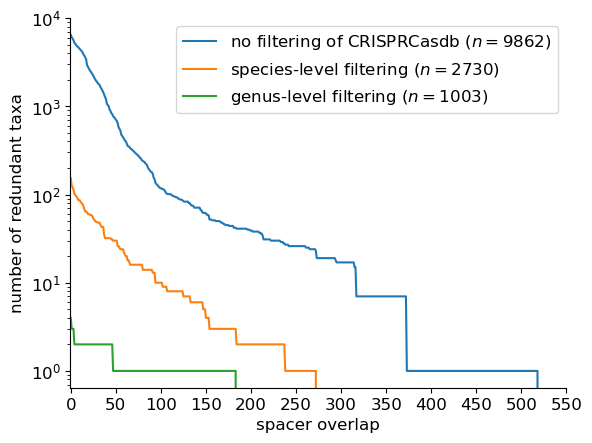

In [21]:
fig, ax = subplots()

fs = 12
PyPlot.semilogy(0:t,num_gbs_all.-reverse(num_clusters_h_all[1:end-1]))
PyPlot.semilogy(0:t,num_gbs.-reverse(num_clusters_h[1:end-1]))
PyPlot.semilogy(0:t,num_gbs_gen.-reverse(num_clusters_h_gen[1:end-1]))
ylabel("number of redundant taxa", fontsize=fs)
xlim(-0.5,t+.5)
PyPlot.xticks(0:50:550, fontsize=fs)

xlabel("spacer overlap", fontsize=fs)

PyPlot.yticks(fontsize=fs)

legend(["no filtering of CRISPRCasdb (\$n=$num_gbs_all\$)",
        "species-level filtering (\$n=$num_gbs\$)",
        "genus-level filtering (\$n=$num_gbs_gen\$)"], fontsize=fs)

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

# PyPlot.savefig("num-redundant-taxa.svg",format="svg")

## Fig. S2C (inset)

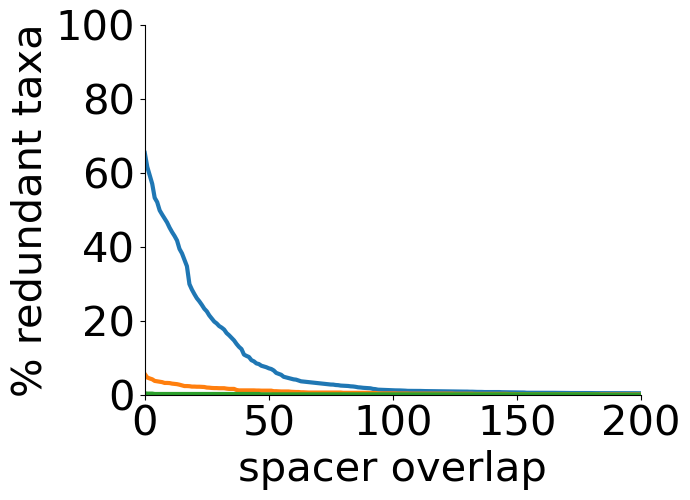

In [22]:
fig, ax = subplots()


fs = 30
PyPlot.plot(0:t,(num_gbs_all.-reverse(num_clusters_h_all[1:end-1]))/num_gbs_all*100, linewidth=3)
PyPlot.plot(0:t,(num_gbs.-reverse(num_clusters_h[1:end-1]))/num_gbs*100, linewidth=3)
PyPlot.plot(0:t,(num_gbs_gen.-reverse(num_clusters_h_gen[1:end-1]))/num_gbs_gen*100, linewidth=3)
ylabel("% redundant taxa", fontsize=fs)
xlim(0,200)
PyPlot.xticks(0:50:200, fontsize=fs)
ylim(0,100)

xlabel("spacer overlap", fontsize=fs)

PyPlot.yticks(fontsize=fs)

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

# PyPlot.savefig("perc-redundant-taxa.svg",format="svg")